<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
以下代码为 <a href="http://mng.bz/orYv">《从零开始构建大型语言模型》</a> 一书的补充代码，作者为 <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>中文翻译和代码详细注释由Lux整理，Github下载地址：<a href="https://github.com/luxianyu">https://github.com/luxianyu</a>
    
<br>Lux的Github上还有吴恩达深度学习Pytorch版学习笔记及中文详细注释的代码下载
    
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


## 附录 D：为训练循环添加附加功能


- 在本附录中，我们将在训练函数中添加一些更高级的功能，这些功能通常用于模型的预训练和微调；微调内容在第6章和第7章中涉及
- 接下来的三个小节将讨论学习率预热（learning rate warmup）、余弦衰减（cosine decay）以及梯度裁剪（gradient clipping）
- 最后一个小节将这些技术整合到训练函数中


- 我们首先初始化一个模型，重用第5章的代码：


In [1]:
"""
教学模块：GPT 模型基础加载与配置示例
-------------------------------------------------
本模块演示如何在 PyTorch 环境下加载自定义的 GPT 模型（来自 previous_chapters.py），
并解释每一行代码与每个参数的作用，便于教学使用。
"""

# ===============================
# 导入必要的库
# ===============================

from importlib.metadata import version  # 导入 Python 标准库 importlib.metadata 模块中的 version 函数
import torch  # 导入 PyTorch 库，用于深度学习计算

# ===============================
# 打印 PyTorch 版本号
# ===============================

# version("torch") 用于获取当前已安装的 PyTorch 版本字符串
# 例如返回 "2.2.1" 或 "2.4.0"
print("torch version:", version("torch"))


# ===============================
# 导入自定义 GPT 模型
# ===============================

from previous_chapters import GPTModel  
# 说明：
# - GPTModel 是在 previous_chapters.py 文件中定义的一个类。
# - 如果你是从 Sebastian Raschka 的《Build a Large Language Model from Scratch》项目中学习，
#   该文件会包含从嵌入层到多头注意力机制再到输出层的完整 GPT 实现。
#
# 补充说明：
# 若本地没有 previous_chapters.py 文件，可改用如下方式从官方 PyPI 包加载：
# from llms_from_scratch.ch04 import GPTModel
#
# 官方项目地址（可查阅源代码与章节说明）：
# https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg


# ===============================
# 定义 GPT 模型的配置参数
# ===============================

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词汇表大小：GPT 模型能识别的 token 数量（GPT-2 默认为 50257）
    "context_length": 256, # 上下文长度（即模型一次能处理的 token 数）
                           # 原始 GPT-2 模型为 1024，这里缩短为 256，便于教学和快速运行
    "emb_dim": 768,        # 嵌入维度（embedding dimension），即每个 token 被映射为一个 768 维向量
                           # 此配置对应 GPT-2 124M 模型的隐藏层大小
    "n_heads": 12,         # 注意力头数量（multi-head attention 的并行头数）
                           # 每个头分别处理输入的不同特征空间
    "n_layers": 12,        # Transformer 块的层数（即堆叠的注意力 + 前馈网络层数）
                           # GPT-2 小型模型（124M）默认也是 12 层
    "drop_rate": 0.1,      # Dropout 比例：在训练过程中随机屏蔽一定比例的神经元，防止过拟合
                           # 在推理阶段会自动禁用（见 model.eval()）
    "qkv_bias": False      # 是否在 Q、K、V（Query, Key, Value）矩阵中使用偏置项
                           # 一般 False 表示更标准的 GPT 结构
}


# ===============================
# 设置计算设备（CPU / GPU / MPS）
# ===============================

# 解释：
# torch.device 是 PyTorch 用来表示计算设备的对象。
# torch.cuda.is_available() 返回 True 表示系统支持 CUDA（NVIDIA GPU）
# 否则回退为 CPU。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# 设备选择的可选改进方案（适配 Apple Silicon）
# ===============================

# 以下代码块默认被注释掉（教学中可手动启用）
# 作用：在 Apple M1/M2/M3 芯片上使用 Metal Performance Shaders (MPS) 加速
# 对比说明：
# - MPS 比 CPU 快约 2 倍
# - 但损失值（loss）可能有微小差异，因为浮点精度不同

# if torch.cuda.is_available():
#     device = torch.device("cuda")  # 优先使用 NVIDIA GPU
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")   # 如果是 Apple 芯片，使用 MPS 加速
# else:
#     device = torch.device("cpu")   # 否则使用 CPU
#
# print(f"Using {device} device.")  # 打印使用的设备类型，便于调试


# ===============================
# 设置随机种子，保证结果可复现
# ===============================

# torch.manual_seed(123)
# 作用：设置随机数生成器种子，使模型初始化、采样等结果一致
# 对教学、调试、论文复现非常重要
torch.manual_seed(123)


# ===============================
# 初始化 GPT 模型
# ===============================

# 创建一个 GPTModel 实例，并传入配置字典 GPT_CONFIG_124M
# 参数说明：
#   config (dict): 包含模型结构定义的配置参数字典
# 返回值：
#   一个 PyTorch 模型对象，可执行前向传播和推理
model = GPTModel(GPT_CONFIG_124M)


# ===============================
# 设置模型为评估模式
# ===============================

# model.eval() 的作用：
#   1. 禁用 Dropout 层（即让所有神经元都工作）
#   2. 禁用 BatchNorm 的动态均值更新
#   3. 用于推理或验证阶段（inference mode）
# 注意：
#   在训练阶段应使用 model.train()
model.eval();  # 末尾分号可防止 Jupyter 输出模型结构


# ===============================
# 模块运行总结（教学说明）
# ===============================
"""
到此为止，本模块完成了以下步骤：
1. 检查并打印 PyTorch 版本。
2. 从本地或官方包中导入 GPTModel。
3. 定义模型配置（参数结构对应 GPT-2 124M）。
4. 自动选择计算设备（CPU/GPU/MPS）。
5. 固定随机种子以保证可复现性。
6. 初始化并设置模型进入推理模式。

下一步（可在 Notebook 下一个单元执行）：
- 加载训练好的权重文件；
- 或者使用随机初始化模型进行前向推理测试。
"""


torch version: 2.9.0+cpu


'\n到此为止，本模块完成了以下步骤：\n1. 检查并打印 PyTorch 版本。\n2. 从本地或官方包中导入 GPTModel。\n3. 定义模型配置（参数结构对应 GPT-2 124M）。\n4. 自动选择计算设备（CPU/GPU/MPS）。\n5. 固定随机种子以保证可复现性。\n6. 初始化并设置模型进入推理模式。\n\n下一步（可在 Notebook 下一个单元执行）：\n- 加载训练好的权重文件；\n- 或者使用随机初始化模型进行前向推理测试。\n'

- 接下来，使用与第5章相同的代码，我们初始化数据加载器：


In [2]:
"""
教学模块：从网络下载并读取文本文件（the-verdict.txt）
------------------------------------------------------------
本模块演示如何使用 Python 的 requests 库从 GitHub 远程仓库下载文本文件，
并在本地缓存后读取其内容。每行代码均附有详细中文注释，便于教学理解。
"""

# ===============================
# 导入必要的标准库与第三方库
# ===============================

import os       # Python 标准库 os，用于文件和路径操作
import requests # requests 是一个流行的第三方 HTTP 请求库，用于访问网络资源

# ===============================
# 定义文件路径与下载地址
# ===============================

file_path = "the-verdict.txt"  
# 本地文件名（字符串类型）
# - 如果当前目录下存在同名文件，则直接读取；
# - 如果不存在，则从指定 URL 下载。

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
# 文本文件的远程 URL，指向 Sebastian Raschka 教程仓库的 GitHub 原始文件地址


# ===============================
# 判断文件是否存在
# ===============================

if not os.path.exists(file_path):  
    # os.path.exists(path) → 判断指定路径下的文件或文件夹是否存在
    # 返回值：
    #   True  表示存在；
    #   False 表示不存在（需下载）

    # ===========================
    # 如果文件不存在，从网络下载
    # ===========================

    response = requests.get(url, timeout=30)
    # requests.get(url, timeout=30)
    # 参数解释：
    #   url (str): 要请求的资源网址
    #   timeout (int): 最长等待时间（秒），防止网络卡死
    # 返回值：
    #   Response 对象，包含服务器响应的内容、状态码等信息

    response.raise_for_status()
    # raise_for_status()：检查 HTTP 响应状态码
    # 如果状态码不是 200（OK），则抛出异常终止程序
    # 这样可以避免继续处理下载失败或被拦截的请求

    text_data = response.text
    # .text 属性：自动按响应头中的字符编码将响应体解码为字符串
    # 此时 text_data 是包含整篇文本内容的 Python 字符串

    # ===========================
    # 将下载的文本保存到本地文件
    # ===========================

    with open(file_path, "w", encoding="utf-8") as file:
        # open(path, mode, encoding)
        # 参数说明：
        #   path (str): 要写入的文件路径
        #   mode (str): 打开模式，这里为 "w" 表示写入（覆盖旧内容）
        #   encoding (str): 指定文本编码格式为 UTF-8，支持多语言字符
        file.write(text_data)  
        # write(string): 将字符串内容写入文件
        # 若文件不存在，open() 会自动创建新文件

else:
    # ===========================
    # 如果文件已存在，直接读取本地文件
    # ===========================

    with open(file_path, "r", encoding="utf-8") as file:
        # 以只读模式 ("r") 打开文件
        # 同样指定 UTF-8 编码以防止中文或特殊符号乱码
        text_data = file.read()
        # 读取整个文件内容为一个字符串


# ===============================
# 附录：原书使用 urllib 的旧版本实现
# ===============================
# 下面的代码块是原书中提供的版本。
# 它使用 urllib 库（Python 内置），但由于使用旧的网络协议，
# 在部分启用 VPN 的环境下可能无法正确访问 GitHub，
# 因此推荐使用上方 requests 版本，兼容性更好。
# （以下仅作教学参考，不执行）

"""
import os
import urllib.request

if not os.path.exists(file_path):
    # urllib.request.urlopen(url) 会打开远程链接，返回一个类文件对象
    with urllib.request.urlopen(url) as response:
        # .read() 读取字节流；decode('utf-8') 将其转为字符串
        text_data = response.read().decode('utf-8')
    # 将文本写入文件
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    # 若文件已存在，则直接读取
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()
"""
# ===============================
# 模块运行总结（教学说明）
# ===============================
"""
到此为止，本模块实现了以下功能：
1. 定义远程文本文件的下载地址（GitHub URL）。
2. 判断本地是否已有缓存文件。
3. 若无缓存，则使用 requests.get() 下载并保存到本地。
4. 若已有缓存，则直接读取文件内容。
5. 在教学中可打印 text_data[:300] 来查看前几百个字符内容。

优势：
- 使用 requests 库，支持 HTTPS、代理、VPN，更安全可靠。
- 提前设置 timeout 和错误检查，提升健壮性。
"""


'\n到此为止，本模块实现了以下功能：\n1. 定义远程文本文件的下载地址（GitHub URL）。\n2. 判断本地是否已有缓存文件。\n3. 若无缓存，则使用 requests.get() 下载并保存到本地。\n4. 若已有缓存，则直接读取文件内容。\n5. 在教学中可打印 text_data[:300] 来查看前几百个字符内容。\n\n优势：\n- 使用 requests 库，支持 HTTPS、代理、VPN，更安全可靠。\n- 提前设置 timeout 和错误检查，提升健壮性。\n'

In [3]:
"""
教学模块：创建 GPT 模型的训练与验证数据加载器（DataLoader）
------------------------------------------------------------
本模块演示如何将文本数据（text_data）划分为训练集与验证集，
并使用 create_dataloader_v1 函数生成可迭代的 PyTorch 数据加载器。
每一行代码和每个参数均配有详细中文注释，适合教学或讲解使用。
"""

# ===============================
# 导入自定义数据加载器函数
# ===============================

from previous_chapters import create_dataloader_v1
# 说明：
# create_dataloader_v1 是一个自定义函数，用于将原始文本转换为模型可训练的
# token 序列批次（batch），返回 PyTorch DataLoader 对象。
#
# 若本地不存在 previous_chapters.py 文件，可使用官方包中的版本：
# from llms_from_scratch.ch02 import create_dataloader_v1
#
# 该函数通常执行以下步骤：
# 1. 将文本转为 token 序列；
# 2. 按 max_length 和 stride 进行分块；
# 3. 生成 (input, target) 对；
# 4. 打包成 PyTorch Dataset；
# 5. 用 DataLoader 封装，支持批量、打乱等功能。


# ===============================
# 设置训练集与验证集划分比例
# ===============================

train_ratio = 0.90  
# 训练集占全部数据的 90%，验证集占 10%

split_idx = int(train_ratio * len(text_data))  
# split_idx 是划分索引，计算方式为：
#   训练数据长度 = 总字符数 × 0.9
# 用于将 text_data 切分为前 90% 训练集 + 后 10% 验证集


# ===============================
# 设置随机种子以保证数据划分与批次一致
# ===============================

torch.manual_seed(123)
# 设置随机种子保证数据加载时的随机打乱（shuffle）结果可复现
# 注意：只影响使用 torch 产生的随机序列（例如 DataLoader shuffle 顺序）。


# ===============================
# 创建训练集 DataLoader
# ===============================

train_loader = create_dataloader_v1(
    text_data[:split_idx],                        # 训练文本数据（取前 90%）
    batch_size=2,                                 # 每个 batch 的样本数量（此处为 2）
    max_length=GPT_CONFIG_124M["context_length"],  # 每个样本的最大 token 长度（即上下文窗口）
    stride=GPT_CONFIG_124M["context_length"],      # 滑动窗口步长，与 max_length 相同表示不重叠
    drop_last=True,                               # 若最后一个 batch 样本数不足 2，则丢弃
    shuffle=True,                                 # 是否打乱样本顺序（训练集应打乱以提升泛化）
    num_workers=0                                 # 数据加载进程数（0 表示在主进程加载）
)
# 返回值：
#   train_loader：一个 PyTorch DataLoader 对象，可用于训练循环中按 batch 提供数据
# 说明：
#   每个 batch 通常包含两个张量：
#     - input_ids：输入序列（前 n-1 个 token）
#     - target_ids：预测目标（后 n-1 个 token）


# ===============================
# 创建验证集 DataLoader
# ===============================

val_loader = create_dataloader_v1(
    text_data[split_idx:],                        # 验证文本数据（取后 10%）
    batch_size=2,                                 # 每个 batch 样本数量
    max_length=GPT_CONFIG_124M["context_length"],  # 最大 token 长度，与训练集保持一致
    stride=GPT_CONFIG_124M["context_length"],      # 滑动窗口步长
    drop_last=False,                              # 验证阶段不丢弃最后不满批的样本，保留全部数据
    shuffle=False,                                # 验证集不打乱顺序，保持一致性以便比较结果
    num_workers=0                                 # 同样在主进程加载，确保教学环境兼容
)
# 返回值：
#   val_loader：验证集 DataLoader 对象，用于评估模型在未见数据上的性能


# ===============================
# 模块运行总结（教学说明）
# ===============================
"""
到此为止，本模块实现了：
1. 从文本数据中划分训练集（90%）与验证集（10%）；
2. 使用相同的随机种子确保可复现性；
3. 调用 create_dataloader_v1 函数生成两个 DataLoader；
4. 训练集启用 shuffle 与 drop_last，验证集关闭这两项；
5. 两者均使用 GPT 模型配置中的 context_length 作为窗口长度。

补充建议（教学用途）：
- 可使用以下代码快速查看一个 batch 的形状：
    batch = next(iter(train_loader))
    print(batch["input_ids"].shape, batch["target_ids"].shape)
- 输出结果应类似于：
    torch.Size([2, 256]) torch.Size([2, 256])
  表示每批有 2 个样本，每个样本包含 256 个 token。
"""


'\n到此为止，本模块实现了：\n1. 从文本数据中划分训练集（90%）与验证集（10%）；\n2. 使用相同的随机种子确保可复现性；\n3. 调用 create_dataloader_v1 函数生成两个 DataLoader；\n4. 训练集启用 shuffle 与 drop_last，验证集关闭这两项；\n5. 两者均使用 GPT 模型配置中的 context_length 作为窗口长度。\n\n补充建议（教学用途）：\n- 可使用以下代码快速查看一个 batch 的形状：\n    batch = next(iter(train_loader))\n    print(batch["input_ids"].shape, batch["target_ids"].shape)\n- 输出结果应类似于：\n    torch.Size([2, 256]) torch.Size([2, 256])\n  表示每批有 2 个样本，每个样本包含 256 个 token。\n'

## D.1 学习率预热（Learning Rate Warmup）


- 在训练像大型语言模型（LLM）这样复杂的模型时，**引入学习率预热（Learning Rate Warmup）** 可以帮助稳定训练过程。  
- 在学习率预热阶段，我们会**逐步将学习率从一个非常低的初始值（`initial_lr`）增加到用户指定的最大值（`peak_lr`）**。  
- 这样，模型在训练初期会以较小的权重更新幅度进行学习，从而**降低训练过程中出现梯度爆炸或不稳定更新的风险**。


In [4]:
"""
教学模块：训练超参数设置 —— epoch 与学习率（Learning Rate）
------------------------------------------------------------
本模块展示如何设置训练轮数（n_epochs）以及学习率策略的初始值与峰值。
这些参数直接影响模型的训练速度、稳定性与最终效果。
"""

# ===============================
# 训练轮数（Epochs）
# ===============================

n_epochs = 15  
# 含义：
#   一个 epoch 表示模型遍历训练集所有样本一次。
#   若训练集有 1000 个样本，batch_size=2，则一个 epoch 含 500 个 batch。
#
# 设置为 15 表示：
#   模型将完整训练 15 次，通常可根据损失下降趋势调整。
#
# 实际建议：
#   - 过少可能欠拟合（underfitting）；
#   - 过多可能过拟合（overfitting）；
#   - 可配合早停（early stopping）策略动态终止训练。


# ===============================
# 学习率初始值（Initial Learning Rate）
# ===============================

initial_lr = 0.0001  
# 含义：
#   学习率（Learning Rate）是梯度下降更新参数时的步长系数。
#   太大 → 训练震荡、甚至发散；
#   太小 → 收敛速度慢。
#
# 设定为 0.0001（1e-4）作为预热阶段（warm-up）的起始值。
# 训练初期学习率低，可以避免模型权重大幅震荡。


# ===============================
# 学习率峰值（Peak Learning Rate）
# ===============================

peak_lr = 0.01  
# 含义：
#   在学习率调度（scheduler）中，通常会从较低的初始值逐步升高到峰值，
#   然后再逐步下降。
#
# 设为 0.01 表示：
#   模型将在预热阶段后达到最大步长，
#   适用于带 warm-up 或 cosine decay 策略的优化器。
#
# 常见策略：
#   - linear warm-up + cosine decay
#   - one-cycle learning rate
#   - step decay
#
# 学习率调度示例（后续模块中可使用）：
#   optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)
#   scheduler = torch.optim.lr_scheduler.OneCycleLR(
#       optimizer,
#       max_lr=peak_lr,
#       total_steps=len(train_loader) * n_epochs
#   )


# ===============================
# 模块运行总结（教学说明）
# ===============================
"""
本模块定义了三个关键训练超参数：
1. n_epochs：训练轮数（控制训练总时长）
2. initial_lr：学习率初始值（控制训练开始时的步长）
3. peak_lr：学习率峰值（控制最大学习强度）

作用关系（概念图）：
   学习率随训练步数变化：
   0 ───►（warm-up上升）───► peak_lr ───►（衰减阶段）───► 较小学习率收敛

建议实践：
- 可先以 0.0001 → 0.01 的范围测试；
- 若损失震荡过大，可降低 peak_lr；
- 若损失下降过慢，可适度提高 initial_lr。
"""


'\n本模块定义了三个关键训练超参数：\n1. n_epochs：训练轮数（控制训练总时长）\n2. initial_lr：学习率初始值（控制训练开始时的步长）\n3. peak_lr：学习率峰值（控制最大学习强度）\n\n作用关系（概念图）：\n   学习率随训练步数变化：\n   0 ───►（warm-up上升）───► peak_lr ───►（衰减阶段）───► 较小学习率收敛\n\n建议实践：\n- 可先以 0.0001 → 0.01 的范围测试；\n- 若损失震荡过大，可降低 peak_lr；\n- 若损失下降过慢，可适度提高 initial_lr。\n'

- 通常，预热（warmup）步骤的数量占总训练步骤数的 0.1% 到 20% 之间。  
- 我们可以通过计算 `peak_lr`（最大学习率）与 `initial_lr`（初始学习率）之间的差值，并将其除以预热步骤数，来确定每一步学习率应增加的幅度。


In [5]:
"""
教学模块：计算训练总步数与预热阶段步数（Warmup Steps）
------------------------------------------------------------
本模块讲解如何根据 DataLoader 批次数和训练轮数计算总训练步数（total_steps），
并设置 warm-up（预热）阶段的步数比例。每行代码均附详细中文教学注释。
"""

# ===============================
# 计算训练总步数（Total Training Steps）
# ===============================

total_steps = len(train_loader) * n_epochs  
# 含义：
#   total_steps 表示整个训练过程中的“参数更新总次数”。
#
# 计算逻辑：
#   len(train_loader) → 每个 epoch 中的 batch 数量
#   n_epochs → 总训练轮数
#
# 举例说明：
#   若 train_loader 每轮有 500 个 batch，n_epochs=15，
#   则 total_steps = 500 * 15 = 7500。
#
# 意义：
#   优化器每次更新参数即为一个 step，因此该值用于控制学习率调度（scheduler）
#   的完整周期长度（如 OneCycleLR 或 CosineAnnealingLR）。


# ===============================
# 设置学习率预热步数（Warmup Steps）
# ===============================

warmup_steps = int(0.2 * total_steps)  
# 含义：
#   warm-up（预热）是训练初期的一种稳定策略：
#   让学习率从 initial_lr 缓慢上升到 peak_lr，
#   避免初始梯度过大造成训练不稳定。
#
# 参数解释：
#   0.2 → 表示 warm-up 占总训练步数的 20%
#   int() → 将计算结果取整为整数
#
# 举例说明：
#   若 total_steps = 7500，
#   则 warmup_steps = int(0.2 * 7500) = 1500。
#
# 实际效果：
#   前 1500 个 step：学习率从 0.0001 增长到 0.01；
#   后 6000 个 step：学习率逐步衰减至较小值（由调度器控制）。


# ===============================
# 输出 warm-up 步数，便于确认计算结果
# ===============================

print(warmup_steps)
# 输出示例：
#   若 total_steps = 7500，则打印结果为：
#   1500


# ===============================
# 模块运行总结（教学说明）
# ===============================
"""
到此为止，本模块完成：
1. 计算 total_steps：模型在整个训练过程中更新参数的总次数；
2. 设定 warmup_steps：其中 20% 的步数用于学习率逐步升高；
3. 打印 warmup_steps，便于调试和验证比例是否符合预期。

教学提示：
- warm-up 有助于训练初期稳定收敛；
- 若模型较大或 batch_size 较小，可适当提高 warm-up 比例；
- 若模型收敛较慢或 loss 长期震荡，可减少 warm-up 时长。
"""


27


'\n到此为止，本模块完成：\n1. 计算 total_steps：模型在整个训练过程中更新参数的总次数；\n2. 设定 warmup_steps：其中 20% 的步数用于学习率逐步升高；\n3. 打印 warmup_steps，便于调试和验证比例是否符合预期。\n\n教学提示：\n- warm-up 有助于训练初期稳定收敛；\n- 若模型较大或 batch_size 较小，可适当提高 warm-up 比例；\n- 若模型收敛较慢或 loss 长期震荡，可减少 warm-up 时长。\n'

- 注意：印刷版书籍中误留了一行代码 `warmup_steps = 20`，这行代码实际上没有被使用，可以安全地忽略。


In [6]:
# ===============================================================
# 学习率预热 (Warm-up) 与优化器 (Optimizer) 的训练流程示例
# ===============================================================

# -------------------------------
# 计算学习率增量（线性增长的步长）
# -------------------------------
lr_increment = (peak_lr - initial_lr) / warmup_steps
# 含义：
# - peak_lr: 目标最大学习率（例如 0.01）
# - initial_lr: 初始学习率（例如 0.0001）
# - warmup_steps: 预热阶段的总步数（例如总训练步数的20%）
# 计算方式：
#   每训练一步，学习率增加 lr_increment = (peak_lr - initial_lr)/warmup_steps
# 这样做可以让学习率从 initial_lr 平滑上升到 peak_lr，避免训练初期震荡

# -------------------------------
# 初始化全局步数计数器
# -------------------------------
global_step = -1
# 含义：
# - global_step 表示全局训练步数（batch 数量的累计）
# - 初始设为 -1 是为了在第一次循环时自增为 0

# -------------------------------
# 存储学习率变化轨迹
# -------------------------------
track_lrs = []
# 含义：
# - 用一个列表保存每一步训练时的学习率值
# - 方便在训练结束后绘制“学习率曲线（Learning Rate Schedule）”

# -------------------------------
# 定义优化器 (AdamW)
# -------------------------------
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
# 参数说明：
# - model.parameters(): 传入模型中所有可训练参数
# - weight_decay=0.1: 权重衰减（L2正则化），用于防止过拟合
# AdamW 优化器特点：
# - 与传统 Adam 不同，AdamW 把权重衰减与梯度更新解耦，效果更稳定
# - 适用于 Transformer、GPT 等大型模型

# -------------------------------
# 开始训练循环
# -------------------------------
for epoch in range(n_epochs):  
    # 外层循环：遍历所有 epoch（完整训练轮次）
    for input_batch, target_batch in train_loader:  
        # 内层循环：从 train_loader 中取出每个 batch 的数据
        # - input_batch: 模型输入序列
        # - target_batch: 模型输出的目标序列（标签）

        # 梯度清零，防止梯度累积
        optimizer.zero_grad()

        # 全局步数 +1
        global_step += 1

        # -------------------------------
        # 学习率预热策略（Warm-up）
        # -------------------------------
        if global_step < warmup_steps:
            # 如果当前步数还处于预热阶段：
            # 让学习率从 initial_lr 逐步线性上升到 peak_lr
            lr = initial_lr + global_step * lr_increment
        else:
            # 超过 warmup 阶段后，学习率保持为 peak_lr
            lr = peak_lr

        # -------------------------------
        # 将当前学习率应用到优化器参数组中
        # -------------------------------
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        # 含义：
        # - optimizer.param_groups 是一个包含模型参数信息的列表
        # - 每个 param_group 对应一组参数（例如 embedding 层、线性层等）
        # - 我们将计算好的 lr 写入每个 param_group，使优化器使用该学习率

        # 将当前步的学习率存储起来
        track_lrs.append(optimizer.param_groups[0]["lr"])

        # -------------------------------
        # 计算损失并进行反向传播（此处省略）
        # -------------------------------
        # 这里通常包含以下步骤：
        # 1. 输出预测：outputs = model(input_batch)
        # 2. 计算损失：loss = loss_fn(outputs, target_batch)
        # 3. 反向传播：loss.backward()
        # 4. 参数更新：optimizer.step()
        # 但本代码仅演示学习率调度过程，故省略“损失与更新”部分


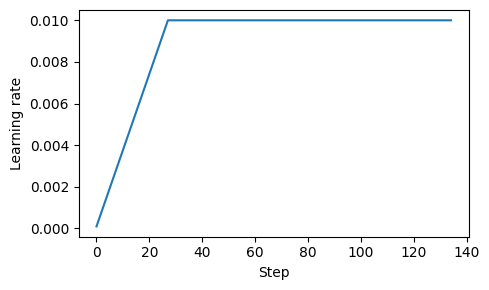

In [7]:
# ===============================================================
# 可视化学习率 (Learning Rate) 随训练步数的变化曲线
# ===============================================================

# 导入 Matplotlib 库中的 pyplot 模块，用于绘图
import matplotlib.pyplot as plt

# -------------------------------
# 创建一个新的图形窗口
# -------------------------------
plt.figure(figsize=(5, 3))
# 参数说明：
# - figsize=(5, 3)：设置图像的宽度为 5 英寸，高度为 3 英寸
#   单位是英寸，1 英寸 ≈ 2.54 厘米
#   此参数影响图像在 Notebook 或 PDF 中的显示比例

# -------------------------------
# 设置纵轴与横轴的标签
# -------------------------------
plt.ylabel("Learning rate")   # 纵轴标签：学习率
plt.xlabel("Step")            # 横轴标签：训练步数

# -------------------------------
# 计算总训练步数
# -------------------------------
total_training_steps = len(train_loader) * n_epochs
# 含义：
# - len(train_loader)：每个 epoch 中的 batch 数量（即训练步数）
# - n_epochs：训练的总轮数
# - 两者相乘得到总的训练步数，用于横轴刻度
# 示例：如果 len(train_loader)=100，n_epochs=15，则总步数为 1500

# -------------------------------
# 绘制学习率随步数变化的折线图
# -------------------------------
plt.plot(range(total_training_steps), track_lrs)
# 参数说明：
# - range(total_training_steps)：生成从 0 到 (总步数-1) 的整数序列，作为横轴（步数）
# - track_lrs：记录了每一步的学习率值，作为纵轴
# - plt.plot()：绘制二维折线图
# 结果：可以看到学习率从 initial_lr 线性上升到 peak_lr 的过程，
#       如果预热结束后学习率保持不变，曲线后段将是一条水平线

# -------------------------------
# 调整布局，防止标签或标题被遮挡
# -------------------------------
plt.tight_layout()
# 作用：
# - 自动调整子图间距，使标签、标题不重叠
# - 在保存或展示图像前，通常都应调用一次

# -------------------------------
# 保存图像到文件
# -------------------------------
plt.savefig("1.pdf")
# 参数说明：
# - "1.pdf"：输出文件名，可改为 "lr_schedule.pdf" 等
# - 保存格式由文件扩展名决定，可支持 jpg、png、svg、pdf 等格式
# 优点：
# - 方便在报告或论文中直接引用学习率曲线

# -------------------------------
# 显示图像
# -------------------------------
plt.show()
# 含义：
# - 在 Jupyter Notebook 或交互式环境中弹出图像窗口
# - 若在脚本中运行（如 .py 文件），plt.show() 必须调用，否则图像不会显示


## D.2 余弦衰减（Cosine Decay）

- 另一种用于训练复杂深度神经网络的常用技术是 **余弦衰减（cosine decay）**，它同样会在训练过程中调整学习率。
- 在余弦衰减中，学习率按照余弦曲线变化，从初始值逐渐下降到接近零，遵循一个半余弦周期。
- 这种逐步减小的方式旨在随着模型权重的改进而减慢学习速度；它可以降低训练过程中越过最优点的风险，这对于在训练后期保持稳定性至关重要。
- 相比线性衰减，余弦衰减因其在学习率调整上的平滑过渡而更受青睐，但线性衰减在实践中也被广泛使用（例如 [OLMo: Accelerating the Science of Language Models](https://arxiv.org/abs/2402.00838)）。


In [8]:
"""
教学模块：带 Warm-up 与 Cosine Annealing 的学习率调度示例
------------------------------------------------------------
本模块展示如何在训练 GPT 模型时，结合线性预热（Warm-up）和余弦退火（Cosine Annealing）
动态调整学习率，并将每一步的学习率记录到 track_lrs 列表中，用于可视化。
每行代码和每个参数均有详细中文注释，便于教学使用。
"""

# ===============================
# 设置最小学习率（cosine annealing 的下限）
# ===============================
min_lr = 0.1 * initial_lr
# 含义：
# - min_lr: 余弦衰减阶段的最小学习率
# - 设为 initial_lr 的 10%，避免学习率衰减到 0，保持微小更新
# - 公式示例：initial_lr = 0.0001 → min_lr = 0.00001

# ===============================
# 清空学习率记录列表
# ===============================
track_lrs = []
# 含义：
# - 用于记录训练过程中每一步的实际学习率
# - 后续可以用 matplotlib 绘制学习率曲线，便于分析

# ===============================
# 重新计算线性 warmup 的步长
# ===============================
lr_increment = (peak_lr - initial_lr) / warmup_steps
# 含义：
# - 每一步 warmup 学习率增加的量
# - 使学习率从 initial_lr 平滑线性增长到 peak_lr

# ===============================
# 初始化全局步数计数器
# ===============================
global_step = -1
# 含义：
# - global_step 表示当前训练总步数（batch 累计）
# - 初始设为 -1 是为了在第一次循环时自增为 0

# ===============================
# 开始训练循环（示例：仅展示学习率调度）
# ===============================
for epoch in range(n_epochs):
    # 遍历所有训练轮次（epoch）
    for input_batch, target_batch in train_loader:
        # 遍历训练集每个 batch
        # input_batch: 输入 token 序列
        # target_batch: 预测目标 token 序列

        # -------------------------------
        # 梯度清零
        # -------------------------------
        optimizer.zero_grad()
        # 含义：
        # - 清空上一批次的梯度，避免梯度累加

        # -------------------------------
        # 全局步数自增
        # -------------------------------
        global_step += 1

        # -------------------------------
        # 学习率调整（Warm-up + Cosine Annealing）
        # -------------------------------
        if global_step < warmup_steps:
            # 线性预热阶段
            lr = initial_lr + global_step * lr_increment
            # 解释：
            # - 从 initial_lr 开始，每步增加 lr_increment
            # - 直到达到 peak_lr，确保训练初期稳定
        else:
            # 预热阶段结束后，使用余弦退火（Cosine Annealing）
            progress = ((global_step - warmup_steps) / 
                        (total_training_steps - warmup_steps))
            # progress:
            # - 当前余弦衰减阶段的相对进度
            # - 范围从 0 → 1
            # - 用于计算余弦函数输入

            lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
            # 余弦退火公式解释：
            # - math.cos(math.pi * progress) ∈ [-1, 1]
            # - 通过 0.5 * (1 + cos(...)) 映射到 [0,1] 区间
            # - 最终 lr ∈ [min_lr, peak_lr]
            # - 优势：学习率先从 peak_lr 缓慢下降到 min_lr，训练平滑收敛

        # -------------------------------
        # 将计算好的学习率应用到优化器
        # -------------------------------
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        # 解释：
        # - optimizer.param_groups 是一个列表，包含模型中每组参数
        # - 可以对不同组参数设置不同学习率
        # - 此处将 lr 应用于所有参数组

        # -------------------------------
        # 记录当前步的学习率
        # -------------------------------
        track_lrs.append(optimizer.param_groups[0]["lr"])
        # 含义：
        # - 保存第一个参数组的学习率（因为所有组 lr 相同）
        # - 后续可绘制学习率曲线，直观展示 warmup + cosine 变化过程

        # -------------------------------
        # 计算损失并更新权重（省略）
        # -------------------------------
        # 这里通常包含：
        # 1. outputs = model(input_batch)
        # 2. loss = loss_fn(outputs, target_batch)
        # 3. loss.backward()
        # 4. optimizer.step()
        # 本示例重点在学习率调度，故未展示具体损失计算


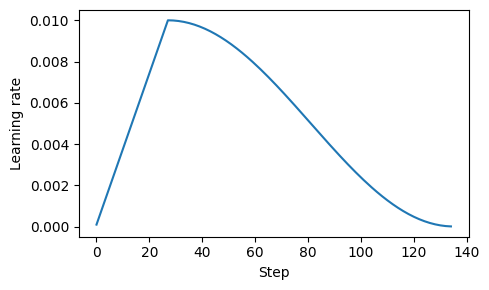

In [9]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("2.pdf")
plt.show()

## D.3 梯度裁剪（Gradient clipping）

- 梯度裁剪（Gradient clipping）是另一种在训练大型语言模型（LLMs）时用于稳定训练的技巧。  
- 通过设置一个阈值，超过该阈值的梯度会被缩放，使其最大幅度受到限制，从而确保在反向传播过程中模型参数的更新保持在可控范围内。  
- 例如，在 PyTorch 中使用 `clip_grad_norm_` 方法并设置 `max_norm=1.0`，表示梯度的范数会被裁剪，使其最大范数不超过 1.0。  
- 这里的“范数”（norm）指的是模型参数空间中梯度向量的长度（或大小）的度量。  
- 具体来说，这里的范数是 **L2 范数（Euclidean norm，欧几里得范数）**。  
- 从数学上讲，对于一个向量 $\mathbf{v}$，其分量为 $\mathbf{v} = [v_1, v_2, \ldots, v_n]$，L2 范数定义如下：  

$$
\| \mathbf{v} \|_2 = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}
$$


- 矩阵的 L2 范数计算方法类似。  
- 假设我们的梯度矩阵为：
$$
G = \begin{bmatrix}
1 & 2 \\
2 & 4
\end{bmatrix}
$$

- 我们希望将这些梯度以 `max_norm` 为 1 进行裁剪。  

- 首先，计算这些梯度的 L2 范数：
$$
\|G\|_2 = \sqrt{1^2 + 2^2 + 2^2 + 4^2} = \sqrt{25} = 5
$$

- 由于 $\|G\|_2 = 5$ 大于我们的 `max_norm` 1，因此需要将梯度缩放，使其范数恰好为 1。缩放因子计算如下：
$$
\frac{max\_norm}{\|G\|_2} = \frac{1}{5}
$$

- 因此，缩放后的梯度矩阵 $G'$ 如下：
$$
G' = \frac{1}{5} \times G = \begin{bmatrix}
\frac{1}{5} & \frac{2}{5} \\
\frac{2}{5} & \frac{4}{5}
\end{bmatrix}
$$


- 我们来看一下实际操作  
- 首先，初始化一个新模型，并像在常规训练循环中一样计算一个训练批次的损失


In [7]:
"""
教学模块：计算单个批次损失并进行反向传播
------------------------------------------------------------
本模块演示如何使用自定义函数 calc_loss_batch 计算 GPT 模型的损失，
并进行反向传播（backward），为参数更新做准备。
每行代码均附有详细中文注释，便于教学。
"""

# ===============================
# 导入自定义计算损失函数
# ===============================
from previous_chapters import calc_loss_batch
# 说明：
# - calc_loss_batch 是自定义函数，用于计算一个 batch 的 GPT 模型损失
# - 若本地不存在 previous_chapters.py，可使用官方包：
#   from llms_from_scratch.ch05 import calc_loss_batch
#
# 函数主要功能：
# 1. 将输入 input_batch 和 target_batch 转为张量
# 2. 将数据发送到指定 device（CPU/GPU）
# 3. 前向传播计算模型输出
# 4. 使用交叉熵等损失函数计算 loss
# 5. 返回一个可用于 backward 的标量损失张量

# ===============================
# 设置随机种子
# ===============================
torch.manual_seed(123)
# 含义：
# - 保证模型参数初始化可复现
# - 对训练实验可重复性非常重要

# ===============================
# 初始化 GPT 模型
# ===============================
model = GPTModel(GPT_CONFIG_124M)
# 参数说明：
# - GPT_CONFIG_124M: 字典，包含模型配置
#   - vocab_size：词汇表大小
#   - context_length：上下文窗口长度
#   - emb_dim：Embedding 维度
#   - n_heads：注意力头数量
#   - n_layers：Transformer 层数
#   - drop_rate：dropout 概率
#   - qkv_bias：是否使用 QKV bias

# ===============================
# 将模型移动到指定设备
# ===============================
model.to(device)
# 参数说明：
# - device: 计算设备，"cuda" / "mps" / "cpu"
# - model.to(device) 会将模型权重和计算迁移到指定设备，保证前向和反向计算一致

# ===============================
# 计算单个批次的损失
# ===============================
loss = calc_loss_batch(input_batch, target_batch, model, device)
# 参数说明：
# - input_batch: 输入序列张量，形状 [batch_size, context_length]
# - target_batch: 标签张量，形状 [batch_size, context_length]
# - model: GPT 模型实例
# - device: 计算设备
# 返回值：
# - loss: 标量张量（scalar tensor），表示该 batch 的平均损失
# 作用：
# - 用于训练时的反向传播
# - 可以直接调用 loss.backward() 更新梯度

# ===============================
# 反向传播
# ===============================
loss.backward()
# 作用：
# - 根据损失计算模型参数的梯度
# - 每个参数的 grad 属性会被更新
# - 这是优化器 step() 之前必须执行的步骤
# - 注意：optimizer.step() 尚未执行，参数还未更新

# ===============================
# 模块运行总结（教学说明）
# ===============================
"""
通过本模块可以理解：
1. 如何使用自定义函数计算单个 batch 的损失；
2. 将模型和数据迁移到同一设备保证计算正确；
3. 使用 loss.backward() 计算梯度，为后续 optimizer.step() 更新参数做准备。

补充说明：
- 在训练循环中，这段代码通常嵌入在 for batch 循环内部；
- loss.backward() 每执行一次，梯度会累加在参数上；
- 因此在每个 batch 前需要 optimizer.zero_grad() 清零梯度。
"""


'\n通过本模块可以理解：\n1. 如何使用自定义函数计算单个 batch 的损失；\n2. 将模型和数据迁移到同一设备保证计算正确；\n3. 使用 loss.backward() 计算梯度，为后续 optimizer.step() 更新参数做准备。\n\n补充说明：\n- 在训练循环中，这段代码通常嵌入在 for batch 循环内部；\n- loss.backward() 每执行一次，梯度会累加在参数上；\n- 因此在每个 batch 前需要 optimizer.zero_grad() 清零梯度。\n'

- 如果我们调用 `.backward()`，PyTorch 会计算梯度，并将其存储在每个权重（参数）矩阵的 `.grad` 属性中  
- 让我们定义一个工具函数，用于根据所有模型权重计算最大的梯度值


In [8]:
"""
教学模块：查找模型中梯度最大值
------------------------------------------------------------
本模块演示如何遍历模型参数，找到梯度（grad）中绝对值最大的元素。
用于调试和分析训练过程，判断梯度是否过大或过小。
每行代码均附详细中文注释。
"""

# ===============================
# 定义查找最大梯度函数
# ===============================
def find_highest_gradient(model):
    """
    查找模型中所有参数的梯度最大值
    参数：
        model (torch.nn.Module): 待检查梯度的模型
    返回：
        max_grad (torch.Tensor 或 None): 梯度最大值（标量张量），
                                           如果模型没有梯度返回 None
    """
    max_grad = None
    # 初始化 max_grad 为 None，用于后续比较

    # 遍历模型的每个参数
    for param in model.parameters():
        if param.grad is not None:
            # param.grad: 当前参数的梯度张量
            # grad 可能为 None（例如尚未执行 backward 或冻结参数）
            
            grad_values = param.grad.data.flatten()
            # grad.data: 获取张量的数据部分，不影响计算图
            # flatten(): 将多维梯度展平为一维向量，方便取最大值

            max_grad_param = grad_values.max()
            # grad_values.max(): 返回该参数的最大梯度值（标量张量）

            # 更新全局最大梯度
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
                # 如果是第一次或比之前最大值更大，则更新 max_grad

    return max_grad
    # 返回整个模型中梯度的最大值
    # 若模型所有参数 grad 都为 None，则返回 None

# ===============================
# 使用示例：打印模型当前梯度最大值
# ===============================
print(find_highest_gradient(model))
# 输出：
# - 如果模型已经执行过 loss.backward()，会打印当前梯度最大值（标量张量）
# - 用于调试梯度是否过大（可能导致梯度爆炸）或过小（梯度消失）


tensor(0.0414)


- 应用梯度裁剪后，我们可以看到最大的梯度现在明显变小了：


In [9]:
"""
教学模块：梯度裁剪（Gradient Clipping）与最大梯度检查
------------------------------------------------------------
本模块演示如何对模型参数的梯度进行裁剪，以防梯度爆炸，
并使用自定义函数 find_highest_gradient 检查裁剪后的最大梯度。
每行代码均附详细中文注释，适合教学或调试使用。
"""

# ===============================
# 梯度裁剪（Gradient Clipping）
# ===============================
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
# 参数说明：
# - model.parameters(): 需要裁剪梯度的模型参数集合
# - max_norm=1.0: 允许梯度的最大范数（L2 范数）
# 作用：
# - 遍历模型所有参数，对梯度整体进行缩放
# - 如果梯度总范数大于 max_norm，则按比例缩小
# - 防止梯度爆炸（尤其在深层网络或 RNN/Transformer 中）
# 返回值：
# - 返回裁剪前的总梯度范数（标量）
# 使用场景：
# - 在 loss.backward() 之后，optimizer.step() 之前执行

# ===============================
# 检查裁剪后的最大梯度
# ===============================
print(find_highest_gradient(model))
# 作用：
# - 调用之前定义的 find_highest_gradient 函数
# - 返回裁剪后模型中梯度的最大值
# - 有助于验证梯度裁剪是否生效
# 预期效果：
# - 输出值不会大于 max_norm 设置的限制值（取决于梯度分布）


tensor(0.0189)


## D.4 修改后的训练函数


- 现在，让我们将上面介绍的三个概念（学习率预热、余弦衰减和梯度裁剪）添加到第5章中介绍的 `train_model_simple` 函数中，从而创建下面更为完善的 `train_model` 函数：


In [10]:
"""
教学模块：GPT 模型训练函数示例（带 Warm-up + Cosine Annealing + 梯度裁剪 + 评估）
------------------------------------------------------------
本模块展示如何封装完整的训练流程，包括：
1. 学习率调度（Warm-up + Cosine Annealing）
2. 梯度裁剪（Gradient Clipping）
3. 训练/验证集损失记录
4. 训练过程中定期评估模型
5. 样本生成监控
每行代码均附中文详细注释，适合教学或演示使用。
"""

# ===============================
# 导入辅助函数
# ===============================
from previous_chapters import evaluate_model, generate_and_print_sample
# 或者：
# from llms_from_scratch.ch05 import evaluate_model, generate_and_print_sample
#
# 函数功能：
# - evaluate_model: 在训练集和验证集上评估模型平均损失
# - generate_and_print_sample: 使用模型生成文本示例以监控训练效果

# ===============================
# 是否使用原书版本（梯度裁剪判断方式不同）
# ===============================
ORIG_BOOK_VERSION = False
# 说明：
# - True: 使用原书版本（global_step > warmup_steps 才裁剪梯度）
# - False: 修正为 global_step >= warmup_steps，避免 warmup 结束后第一步梯度未裁剪

# ===============================
# 定义训练函数
# ===============================
def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):
    """
    GPT 模型完整训练流程
    参数：
        model: GPT 模型实例
        train_loader: 训练集 DataLoader
        val_loader: 验证集 DataLoader
        optimizer: 优化器实例（如 AdamW）
        device: 计算设备（"cuda"/"cpu"/"mps"）
        n_epochs: 训练轮数
        eval_freq: 每隔多少步评估一次
        eval_iter: 评估时取多少 batch 计算平均损失
        start_context: 样本生成初始文本（监控训练进展）
        tokenizer: 文本分词器
        warmup_steps: 学习率预热步数
        initial_lr: 学习率初始值
        min_lr: 学习率最小值（cosine annealing 下限）
    返回：
        train_losses: 每次评估的训练损失列表
        val_losses: 每次评估的验证损失列表
        track_tokens_seen: 训练过程中累计 token 数量
        track_lrs: 训练过程中每一步学习率变化
    """

    # -------------------------------
    # 初始化记录列表和计数器
    # -------------------------------
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1
    # tokens_seen: 已训练的 token 数
    # global_step: 全局训练步数

    # -------------------------------
    # 获取优化器中当前学习率（peak_lr）
    # -------------------------------
    peak_lr = optimizer.param_groups[0]["lr"]
    # 注意：此处假设所有参数组 lr 相同

    # -------------------------------
    # 计算总训练步数
    # -------------------------------
    total_training_steps = len(train_loader) * n_epochs

    # -------------------------------
    # 计算 warmup 期间每步的学习率增量
    # -------------------------------
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    # ===============================
    # 训练循环
    # ===============================
    for epoch in range(n_epochs):
        model.train()  # 启用训练模式（dropout 等生效）
        for input_batch, target_batch in train_loader:

            optimizer.zero_grad()       # 清空梯度
            global_step += 1           # 全局步数自增

            # -------------------------------
            # 学习率调度（Warm-up + Cosine Annealing）
            # -------------------------------
            if global_step < warmup_steps:
                # 线性 warm-up
                lr = initial_lr + global_step * lr_increment  
            else:
                # 预热结束后，使用余弦退火
                progress = ((global_step - warmup_steps) /
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # 将学习率应用到优化器参数组
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # 记录当前步学习率

            # -------------------------------
            # 前向传播 + 计算损失 + 反向传播
            # -------------------------------
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # 梯度计算

            # -------------------------------
            # 梯度裁剪（Gradient Clipping）
            # -------------------------------
            if ORIG_BOOK_VERSION:
                if global_step > warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            else:
                if global_step >= warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # -------------------------------
            # 参数更新
            # -------------------------------
            optimizer.step()
            tokens_seen += input_batch.numel()  # 累计 token 数

            # -------------------------------
            # 定期评估训练集和验证集
            # -------------------------------
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # 输出当前损失
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # -------------------------------
        # 训练结束每轮生成示例文本，监控模型生成能力
        # -------------------------------
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    # 返回训练过程记录
    return train_losses, val_losses, track_tokens_seen, track_lrs


In [14]:
"""
教学模块：GPT 模型训练执行示例（带完整配置和 tiktoken 分词器）
------------------------------------------------------------
本模块展示如何初始化模型、优化器、分词器，并调用训练函数 train_model。
每行代码附中文详细注释，便于在 Jupyter Notebook 教学或实验中使用。
"""

# ===============================
# 导入 tiktoken 分词器
# ===============================
import tiktoken
# 说明：
# - tiktoken 是 OpenAI GPT 系列模型官方推荐的分词器库
# - 可以高效地将文本转为 token ID，用于 GPT 模型训练和生成

# ===============================
# 可选：记录训练执行时间
# ===============================
# import time
# start_time = time.time()
# 说明：
# - 可用于统计训练总耗时
# - start_time 记录训练开始时间（秒为单位）

# ===============================
# 设置随机种子
# ===============================
torch.manual_seed(123)
# 含义：
# - 保证模型初始化可复现
# - 对实验结果稳定性和教学演示非常重要

# ===============================
# 初始化 GPT 模型并迁移到指定设备
# ===============================
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
# GPT_CONFIG_124M: 字典，包含模型超参数（embedding 维度、层数、注意力头数等）
# device: "cuda"/"cpu"/"mps"，保证模型与输入在同一设备

# ===============================
# 定义优化器（AdamW）及学习率
# ===============================
peak_lr = 0.001
optimizer = torch.optim.AdamW(
    model.parameters(),  # 待优化的模型参数
    lr=peak_lr,          # 初始学习率（原书漏写，已修正）
    weight_decay=0.1     # 权重衰减，用于正则化防止过拟合
)

# ===============================
# 初始化分词器
# ===============================
tokenizer = tiktoken.get_encoding("gpt2")
# 说明：
# - "gpt2" 编码方案与 GPT-2/GPT-3 系列模型一致
# - tokenizer 可用于将文本转为 token ID，也可用于生成样本文本

# ===============================
# 设置训练轮数
# ===============================
n_epochs = 15

# ===============================
# 调用训练函数
# ===============================
train_losses, val_losses, tokens_seen, lrs = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    eval_freq=5,           # 每训练 5 步进行一次评估
    eval_iter=1,           # 每次评估取 1 个 batch 计算平均损失
    start_context="Every effort moves you",  # 样本生成初始文本
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,  # 预热步数
    initial_lr=1e-5,            # warmup 起始学习率
    min_lr=1e-5                 # cosine annealing 的最小学习率
)
# 返回值：
# - train_losses: 每次评估的训练损失列表
# - val_losses: 每次评估的验证损失列表
# - tokens_seen: 训练过程中累计的 token 数量
# - lrs: 每步学习率变化列表

# ===============================
# 可选：计算训练耗时
# ===============================
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# 说明：
# - 训练完成后，可输出总耗时（分钟）
# - 对实验和教学演示很有用


Ep 1 (Iter 000000): Train loss 10.934, Val loss 10.939
Ep 1 (Iter 000005): Train loss 9.151, Val loss 9.461
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.949, Val loss 8.184
Ep 2 (Iter 000015): Train loss 6.362, Val loss 6.876
Every effort moves you,,,,,,,,,,,,,,,,,,, the,,,,,,,,, the,,,,,,,,,,, the,,,,,,,,
Ep 3 (Iter 000020): Train loss 5.851, Val loss 6.607
Ep 3 (Iter 000025): Train loss 5.750, Val loss 6.634
Every effort moves you. "I"I and I had to the to the to the and the of the to the of the to Gisburn, and the of the the of the of the to the to the of the of the of the to the of
Ep 4 (Iter 000030): Train loss 4.617, Val loss 6.714
Ep 4 (Iter 000035): Train loss 4.277, Val loss 6.640
Every effort moves you, I was. Gisburn. Gisburn's. Gisburn. Gisburn's of the of Jack's. "I of his I had the of the of the of his of, I had been. I was.
Ep 5 (Iter 000040): Train loss 3.194, Val loss 6.324
Every effort moves you know the, an

- 从上面的结果可以看出，模型一开始生成的是无法理解的词串，而到了后期，它能够生成语法上大致正确的句子。
- 如果检查它在后期生成的几个段落，我们会发现这些内容在训练集中是逐字出现的——它只是简单地记住了训练数据。
- 注意，这里的过拟合发生是因为我们使用了非常非常小的训练集，并且对其进行了多次迭代：
  - 这里的 LLM 训练主要用于教育目的；我们主要是想观察模型是否能够学习生成连贯的文本。
  - 我们没有在大量昂贵硬件上花费数周或数月训练这个模型，而是直接加载了预训练权重。


- 快速检查学习率是否按预期变化


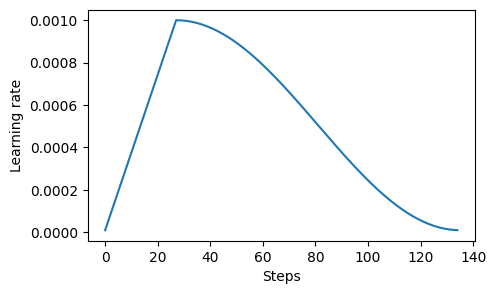

In [15]:
"""
教学模块：绘制训练过程中学习率变化曲线
------------------------------------------------------------
本模块演示如何使用 Matplotlib 可视化训练过程中每一步的学习率，
帮助直观分析 Warm-up + Cosine Annealing 调度效果。
每行代码均附中文详细注释，便于教学使用。
"""

# ===============================
# 创建图形窗口
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
# 参数说明：
# - figsize=(5, 3)：设置图像宽 5 英寸，高 3 英寸
# - 图像尺寸可根据 Notebook 或报告需求调整

# ===============================
# 绘制学习率曲线
# ===============================
plt.plot(range(len(lrs)), lrs)
# 参数说明：
# - range(len(lrs))：生成横轴坐标序列，对应每一步训练步数
# - lrs：纵轴数据，记录每步实际学习率
# - plt.plot()：绘制折线图，可直观展示学习率随步数变化

# ===============================
# 添加坐标轴标签
# ===============================
plt.ylabel("Learning rate")  # 纵轴标签
plt.xlabel("Steps")          # 横轴标签

# ===============================
# 显示图像
# ===============================
plt.show()
# 说明：
# - 在 Notebook 中显示图形
# - 学习率曲线通常包含：
#   1. 前期 Warm-up 阶段：学习率线性上升
#   2. 后期 Cosine Annealing 阶段：学习率逐步下降至 min_lr


- 快速查看损失曲线


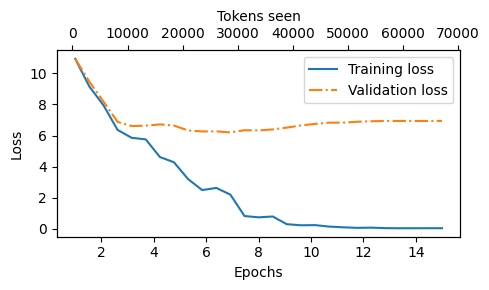

In [16]:
"""
教学模块：绘制训练与验证损失曲线
------------------------------------------------------------
本模块演示如何使用自定义函数 plot_losses 绘制训练过程中
训练集与验证集的损失变化曲线，便于分析模型收敛情况。
每行代码均附中文详细注释，便于教学使用。
"""

# ===============================
# 导入绘制损失曲线函数
# ===============================
from previous_chapters import plot_losses
# 或者：
# from llms_from_scratch.ch05 import plot_losses
# 说明：
# - plot_losses 是自定义绘图函数
# - 接收训练轮数或 token 累计数，以及 train/val 损失列表
# - 绘制折线图展示训练过程收敛趋势

# ===============================
# 创建与训练轮数对应的 tensor
# ===============================
epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
# 参数说明：
# - torch.linspace(start, end, steps)：生成从 start 到 end 的等间距 tensor
# - start=1, end=n_epochs：对应训练轮数
# - steps=len(train_losses)：根据记录的训练损失数量生成横坐标
# - 用于将每次评估的 train_losses 和 val_losses 映射到对应 epoch 位置

# ===============================
# 调用绘图函数
# ===============================
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
# 参数说明：
# - epochs_tensor：横轴坐标（训练轮/步数）
# - tokens_seen：累计训练 token 数（可作为辅助横轴）
# - train_losses：训练集损失列表
# - val_losses：验证集损失列表
# 功能：
# - 绘制训练与验证损失随训练进度的变化折线图
# - 直观观察模型收敛和过拟合情况

# ===============================
# 调整布局、防止标签重叠，并保存图像
# ===============================
plt.tight_layout()  # 自动调整子图布局
plt.savefig("3.pdf")  # 保存为 PDF 文件，方便报告或论文使用

# ===============================
# 显示图像
# ===============================
plt.show()
# 说明：
# - 在 Notebook 或交互环境中显示训练与验证损失曲线
# - 曲线形状分析：
#   1. 若训练损失下降而验证损失上升，可能出现过拟合
#   2. 若训练与验证损失都平稳下降，说明模型收敛良好


- 请注意，这里模型出现过拟合是因为数据集为了教学目的保持非常小（以便代码可以在笔记本电脑上运行）
- 如果希望在更大数据集上进行更长时间的预训练，请参见 [../../ch05/03_bonus_pretraining_on_gutenberg](../../ch05/03_bonus_pretraining_on_gutenberg)
